In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from tqdm import tqdm
from numba import njit

In [2]:
hbar = 1.0
m = 1.0

compute = 1  # set to 0 if want to read stored results

In [7]:
exact_path = 'Exact'
classical_path = 'Classical'
polymer_path = 'Polymer'
cube_path = 'Cube'

# Potential Functions

In [4]:
@njit
def harmonic(x):
    return 0.5 * x ** 2

@njit
def slightly_anharmonic(x):
    return 0.5 * x**2 + 0.1 * x**3 + 0.01 * x**4

@njit
def anharmonic(x):
    return 0.25 * x**4

# Exact Quantum Solution

In [6]:
def exact_quantum(n_max, beta, potential, t_end, t_N):

    potential_coefficients = {
        'harmonic': [1/2,0,0],
        'slightly_anharmonic': [1/2,1/10,1/100],
        'anharmonic': [0,0,1/4]
    }

    dim = n_max + 4

    # Annihilation operator
    a = np.zeros((dim, dim))
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)

    # Creation operator
    adag = a.T

    # Position operator
    x = np.sqrt(hbar/(2*m)) * (a + adag)

    x2 = x @ x
    x3 = x2 @ x
    x4 = x3 @ x

    x_powers = [x2,x3,x4]

    V = np.zeros((dim,dim))
    for i in range(0,3):
        V += potential_coefficients[potential][i] * x_powers[i]

    # Kinetic energy operator

    dv = np.sqrt(m * hbar / 2) * (adag - a)

    T = -(dv @ dv) / (2 * m)

    # Hamiltonian
    H = T + V

    H = H[:n_max,:n_max]

    # Diagonalize Hamiltonian
    E, psi = eigh(H)

    # Partition function
    exp_beta_E = np.exp(-beta * E)
    Z = np.sum(exp_beta_E)

    # Operator A = x
    A = x[:n_max,:n_max]
    A_mat = psi.T @ A @ psi

    # Build outer products for broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            exp_beta_E[:, None],
            (exp_beta_E[None, :] - exp_beta_E[:, None]) / (beta * dE)
        )

    # Matrix element product (A_nm * A_mn)
    A_prod = A_mat * A_mat.T

    # Time evolution
    times = np.linspace(0, t_end, t_N)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, A_prod).real / Z

    return times, C_t

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [8]:
beta = 1
if compute == 1:
    exact_harmonic = exact_quantum(10,beta,'harmonic',25,250)
    np.save(f'{exact_path}/harmonic.npy', exact_harmonic)

In [ ]:
exact_harmonic = np.load(f'{exact_path}/harmonic.npy')

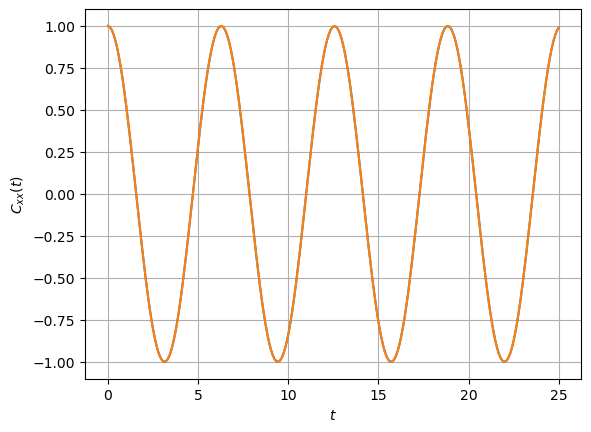

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(exact_harmonic[0], exact_harmonic[1])
plt.plot(exact_harmonic[0], np.cos(exact_harmonic[0]))
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()
plt.clf()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [11]:
beta = 1
if compute == 1:
    exact_slightly_anharmonic_highT = exact_quantum(20,beta,'slightly_anharmonic',25,250)
    np.save(f'{exact_path}/slightly_anharmonic_highT.npy', exact_slightly_anharmonic_highT)

In [13]:
exact_slightly_anharmonic_highT = np.load(f'{exact_path}/slightly_anharmonic_highT.npy')

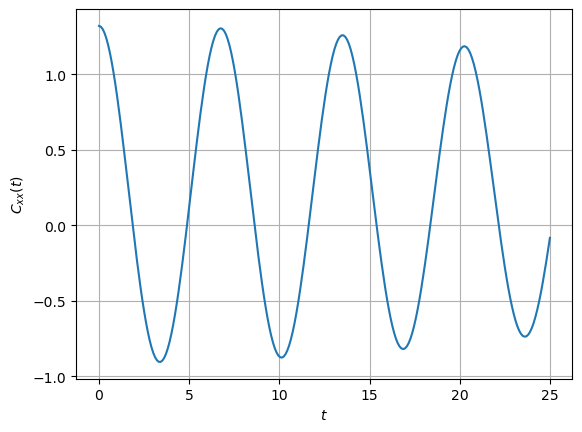

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(exact_slightly_anharmonic_highT[0], exact_slightly_anharmonic_highT[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()
plt.clf()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [15]:
beta = 8
if compute == 1:
    exact_slightly_anharmonic_lowT = exact_quantum(10,beta,'slightly_anharmonic',25,250)
    np.save(f'{exact_path}/slightly_anharmonic_lowT.npy', exact_slightly_anharmonic_lowT)

In [16]:
exact_slightly_anharmonic_lowT = np.load(f'{exact_path}/slightly_anharmonic_lowT.npy')

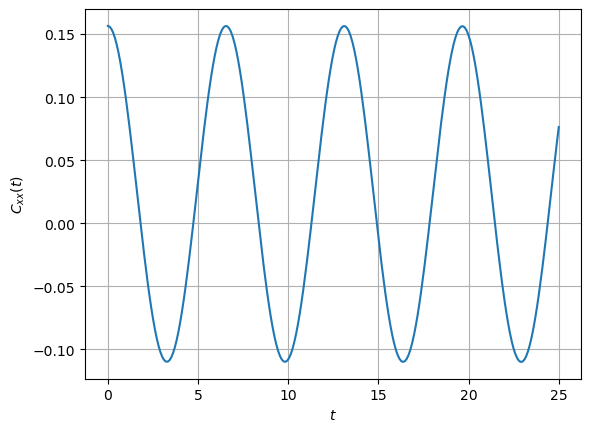

<Figure size 640x480 with 0 Axes>

In [17]:
plt.plot(exact_slightly_anharmonic_lowT[0], exact_slightly_anharmonic_lowT[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()
plt.clf()

$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [18]:
beta = 1
if compute == 1:
    exact_anharmonic_highT = exact_quantum(20,beta,'anharmonic',25,250)
    np.save(f'{exact_path}/anharmonic_highT.npy', exact_anharmonic_highT)

In [19]:
exact_anharmonic_highT = np.load(f'{exact_path}/anharmonic_highT.npy')

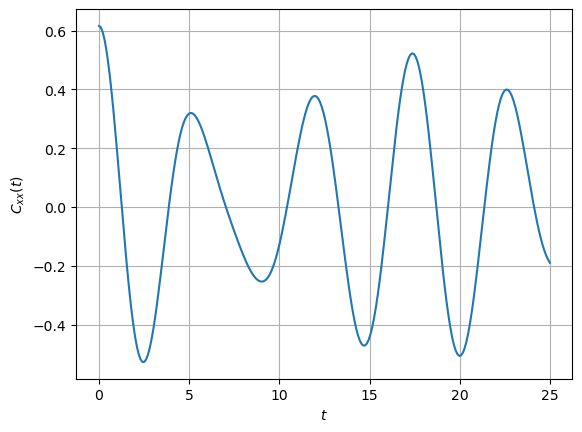

<Figure size 640x480 with 0 Axes>

In [20]:
plt.plot(exact_anharmonic_highT[0], exact_anharmonic_highT[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()
plt.clf()

$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [21]:
beta = 8
if compute == 1:
    exact_anharmonic_lowT = exact_quantum(10,beta,'anharmonic',25,250)
    np.save(f'{exact_path}/anharmonic_lowT.npy', exact_anharmonic_lowT)

In [22]:
exact_anharmonic_lowT = np.load(f'{exact_path}/anharmonic_lowT.npy')

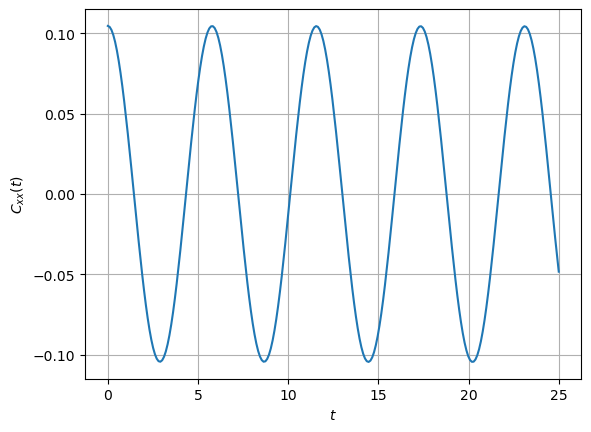

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(exact_anharmonic_lowT[0], exact_anharmonic_lowT[1])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.show()
plt.clf()

# Classical Solution

In [24]:
@njit
def F_harmonic(x):
    return -x

@njit
def F_slightly_anharmonic(x):
    return -x - 3*x**2/10 - x**3/25

@njit
def F_anharmonic(x):
    return -x**3

In [106]:
@njit
def verlet_harmonic(x_init, v_init, time, delta_t):
    N = int(time / delta_t)
    x_verlet = np.zeros(N)
    v_verlet = np.zeros(N)
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    for i in range(N - 1):
        f = F_harmonic(x_verlet[i])
        x_new = x_verlet[i] + delta_t * v_verlet[i] + 0.5 * delta_t**2 * f / m
        f_new = F_harmonic(x_new)
        v_new = v_verlet[i] + 0.5 * delta_t * (f + f_new) / m

        x_verlet[i + 1] = x_new
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

@njit
def verlet_slightly_anharmonic(x_init, v_init, time, delta_t):
    N = int(time / delta_t)
    x_verlet = np.zeros(N)
    v_verlet = np.zeros(N)
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    for i in range(N - 1):
        f = F_slightly_anharmonic(x_verlet[i])
        x_new = x_verlet[i] + delta_t * v_verlet[i] + 0.5 * delta_t**2 * f / m
        f_new = F_slightly_anharmonic(x_new)
        v_new = v_verlet[i] + 0.5 * delta_t * (f + f_new) / m

        x_verlet[i + 1] = x_new
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

@njit
def verlet_anharmonic(x_init, v_init, time, delta_t):
    N = int(time / delta_t)
    x_verlet = np.zeros(N)
    v_verlet = np.zeros(N)
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    for i in range(N - 1):
        f = F_anharmonic(x_verlet[i])
        x_new = x_verlet[i] + delta_t * v_verlet[i] + 0.5 * delta_t**2 * f / m
        f_new = F_anharmonic(x_new)
        v_new = v_verlet[i] + 0.5 * delta_t * (f + f_new) / m

        x_verlet[i + 1] = x_new
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

In [108]:
def classical(x_low, x_up, x_step, v_low, v_up, v_step, potential, time, delta_t, beta):
    C_time = np.arange(0, time, delta_t)
    N = len(C_time)

    C_func = np.zeros(N)
    partition_function = 0.0

    x_vals = np.arange(x_low, x_up, x_step)
    v_vals = np.arange(v_low, v_up, v_step)

    for x_init in tqdm(x_vals, desc="Classical Sampling"):
        for v_init in v_vals:
            if potential == 'harmonic':  
                E = harmonic(x_init) + 0.5 * m * v_init**2
                weight = np.exp(-beta * E)
                x_traj, _ = verlet_harmonic(x_init, v_init, time, delta_t)
            elif potential == 'slightly_anharmonic':  
                E = slightly_anharmonic(x_init) + 0.5 * m * v_init**2
                weight = np.exp(-beta * E)
                x_traj, _ = verlet_slightly_anharmonic(x_init, v_init, time, delta_t)
            elif potential == 'anharmonic':  
                E = anharmonic(x_init) + 0.5 * m * v_init**2
                weight = np.exp(-beta * E)
                x_traj, _ = verlet_anharmonic(x_init, v_init, time, delta_t)

            C_func += x_traj * x_init * weight
            partition_function += weight

    C_func /= partition_function
    return C_time, C_func


$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [28]:
beta = 1
if compute == 1:
    classical_harmonic = classical(-6,6,0.05,-5.5,5.5,0.1,'harmonic',25,0.05,beta)
    np.save(f'{classical_path}/harmonic.npy', classical_harmonic)

Classical Sampling: 100%|██████████| 240/240 [00:00<00:00, 1039.63it/s]


In [30]:
classical_harmonic = np.load(f'{classical_path}/harmonic.npy')

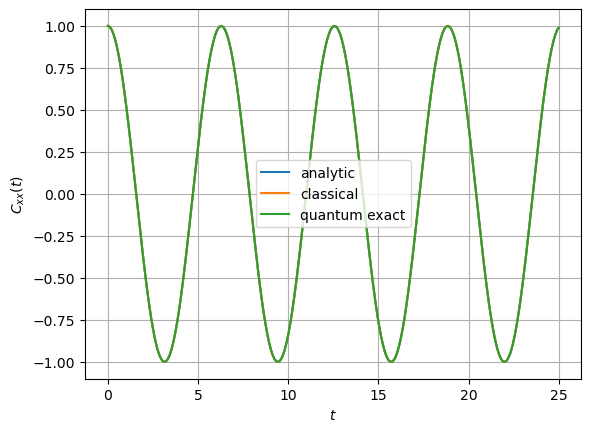

<Figure size 640x480 with 0 Axes>

In [31]:
plt.plot(classical_harmonic[0], np.cos(classical_harmonic[0]),label='analytic')
plt.plot(classical_harmonic[0], classical_harmonic[1],label='classical')
plt.plot(exact_harmonic[0], exact_harmonic[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()
plt.clf()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [109]:
beta = 1
if compute == 1:
    classical_slightly_anharmonic_highT = classical(-8,4.5,0.05,-5.5,5.5,0.1,'slightly_anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/slightly_anharmonic_highT.npy', classical_slightly_anharmonic_highT)

Classical Sampling: 100%|██████████| 250/250 [00:00<00:00, 527.42it/s]


In [111]:
classical_slightly_anharmonic_highT = np.load(f'{classical_path}/slightly_anharmonic_highT.npy')

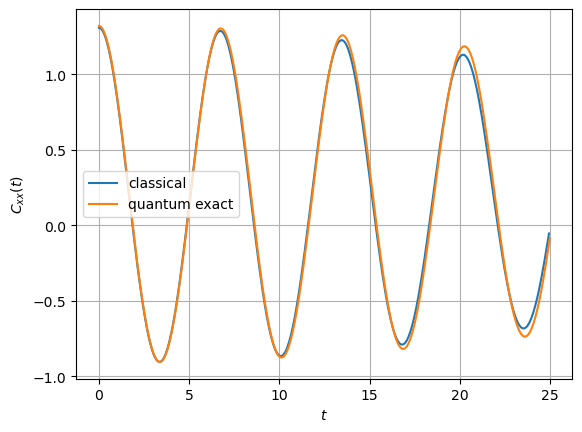

<Figure size 640x480 with 0 Axes>

In [112]:
plt.plot(classical_slightly_anharmonic_highT[0], classical_slightly_anharmonic_highT[1],label='classical')
plt.plot(exact_slightly_anharmonic_highT[0], exact_slightly_anharmonic_highT[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()
plt.clf()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [36]:
beta = 8
if compute == 1:
    classical_slightly_anharmonic_lowT = classical(-3.5,2.5,0.02,-5.5,5.5,0.1,'slightly_anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/slightly_anharmonic_lowT.npy', classical_slightly_anharmonic_lowT)

Classical Sampling: 100%|██████████| 300/300 [00:00<00:00, 710.37it/s]


In [37]:
classical_slightly_anharmonic_lowT = np.load(f'{classical_path}/slightly_anharmonic_lowT.npy')

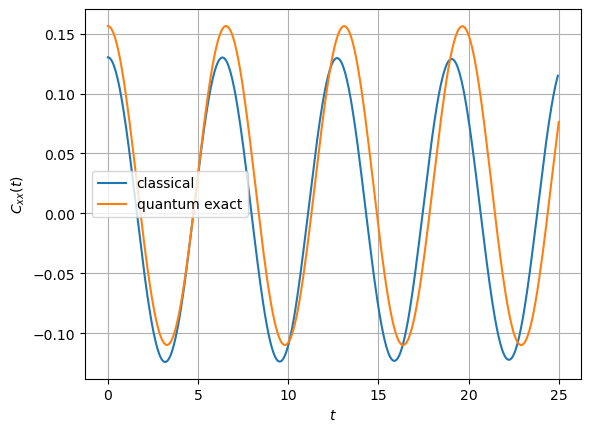

<Figure size 640x480 with 0 Axes>

In [38]:
plt.plot(classical_slightly_anharmonic_lowT[0], classical_slightly_anharmonic_lowT[1],label='classical')
plt.plot(exact_slightly_anharmonic_lowT[0], exact_slightly_anharmonic_lowT[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()
plt.clf()

$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [39]:
beta = 1
if compute == 1:
    classical_anharmonic_highT = classical(-3.5,3.5,0.02,-5.5,5.5,0.05,'anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/anharmonic_highT.npy', classical_anharmonic_highT)

Classical Sampling: 100%|██████████| 350/350 [00:00<00:00, 364.63it/s]


In [40]:
classical_anharmonic_highT = np.load(f'{classical_path}/anharmonic_highT.npy')

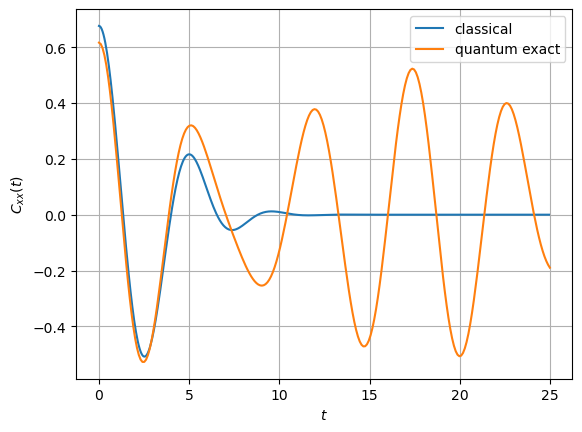

<Figure size 640x480 with 0 Axes>

In [41]:
plt.plot(classical_anharmonic_highT[0], classical_anharmonic_highT[1],label='classical')
plt.plot(exact_anharmonic_highT[0], exact_anharmonic_highT[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()
plt.clf()

$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [42]:
beta = 8
if compute == 1:
    classical_anharmonic_lowT = classical(-3.5,3.5,0.02,-5.5,5.5,0.1,'anharmonic',25,0.05,beta)
    np.save(f'{classical_path}/anharmonic_lowT.npy', classical_anharmonic_lowT)

Classical Sampling: 100%|██████████| 350/350 [00:00<00:00, 896.58it/s]


In [43]:
classical_anharmonic_lowT = np.load(f'{classical_path}/anharmonic_lowT.npy')

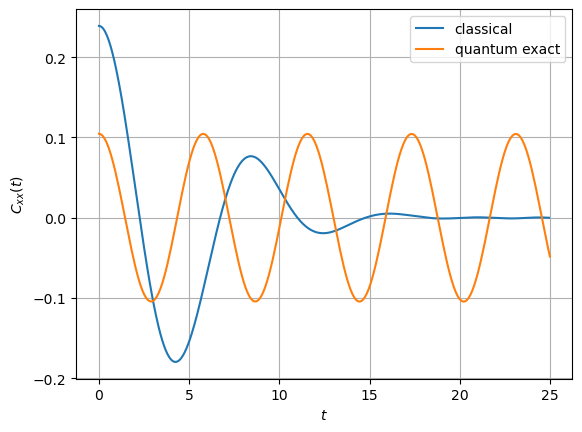

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(classical_anharmonic_lowT[0], classical_anharmonic_lowT[1],label='classical')
plt.plot(exact_anharmonic_lowT[0], exact_anharmonic_lowT[1],label='quantum exact')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.show()
plt.clf()

# Ring Polymer

In [113]:
@njit
def polymer_verlet_harmonic(x_init, v_init, k_eff, time, delta_t, n):
    N = int(time / delta_t)
    x_verlet = np.zeros((N, n))
    v_verlet = np.zeros((N, n))
    x_verlet[0, :] = x_init
    v_verlet[0, :] = v_init

    for i in range(N - 1):
        x = x_verlet[i]
        v = v_verlet[i]
        f = F_harmonic(x)

        # Efficient spring force using periodic boundary
        x_fwd = np.empty(n)
        x_bwd = np.empty(n)
        for j in range(n):
            x_fwd[j] = x[(j + 1) % n]
            x_bwd[j] = x[(j - 1 + n) % n]
        spring_force = -k_eff * (2 * x - x_fwd - x_bwd)

        x_new = x + delta_t * v + (delta_t**2 / (2 * m)) * (f + spring_force)
        x_verlet[i + 1] = x_new

        f_new = F_harmonic(x_new)
        for j in range(n):
            x_fwd[j] = x_new[(j + 1) % n]
            x_bwd[j] = x_new[(j - 1 + n) % n]
        spring_force_new = -k_eff * (2 * x_new - x_fwd - x_bwd)

        v_new = v + (delta_t / (2 * m)) * (f + spring_force + f_new + spring_force_new)
        v_verlet[i + 1] = v_new

    N = x_verlet.shape[0]
    x_avg = np.empty(N)
    for i in range(N):
        s = 0.0
        for j in range(x_verlet.shape[1]):
            s += x_verlet[i, j]
        x_avg[i] = s / x_verlet.shape[1]
    return x_avg

@njit
def polymer_verlet_slightly_anharmonic(x_init, v_init, k_eff, time, delta_t, n):
    N = int(time / delta_t)
    x_verlet = np.zeros((N, n))
    v_verlet = np.zeros((N, n))
    x_verlet[0, :] = x_init
    v_verlet[0, :] = v_init

    for i in range(N - 1):
        x = x_verlet[i]
        v = v_verlet[i]
        f = F_slightly_anharmonic(x)

        # Efficient spring force using periodic boundary
        x_fwd = np.empty(n)
        x_bwd = np.empty(n)
        for j in range(n):
            x_fwd[j] = x[(j + 1) % n]
            x_bwd[j] = x[(j - 1 + n) % n]
        spring_force = -k_eff * (2 * x - x_fwd - x_bwd)

        x_new = x + delta_t * v + (delta_t**2 / (2 * m)) * (f + spring_force)
        x_verlet[i + 1] = x_new

        f_new = F_slightly_anharmonic(x_new)
        for j in range(n):
            x_fwd[j] = x_new[(j + 1) % n]
            x_bwd[j] = x_new[(j - 1 + n) % n]
        spring_force_new = -k_eff * (2 * x_new - x_fwd - x_bwd)

        v_new = v + (delta_t / (2 * m)) * (f + spring_force + f_new + spring_force_new)
        v_verlet[i + 1] = v_new

    N = x_verlet.shape[0]
    x_avg = np.empty(N)
    for i in range(N):
        s = 0.0
        for j in range(x_verlet.shape[1]):
            s += x_verlet[i, j]
        x_avg[i] = s / x_verlet.shape[1]
    return x_avg

@njit
def polymer_verlet_anharmonic(x_init, v_init, k_eff, time, delta_t, n):
    N = int(time / delta_t)
    x_verlet = np.zeros((N, n))
    v_verlet = np.zeros((N, n))
    x_verlet[0, :] = x_init
    v_verlet[0, :] = v_init

    for i in range(N - 1):
        x = x_verlet[i]
        v = v_verlet[i]
        f = F_anharmonic(x)

        # Efficient spring force using periodic boundary
        x_fwd = np.empty(n)
        x_bwd = np.empty(n)
        for j in range(n):
            x_fwd[j] = x[(j + 1) % n]
            x_bwd[j] = x[(j - 1 + n) % n]
        spring_force = -k_eff * (2 * x - x_fwd - x_bwd)

        x_new = x + delta_t * v + (delta_t**2 / (2 * m)) * (f + spring_force)
        x_verlet[i + 1] = x_new

        f_new = F_anharmonic(x_new)
        for j in range(n):
            x_fwd[j] = x_new[(j + 1) % n]
            x_bwd[j] = x_new[(j - 1 + n) % n]
        spring_force_new = -k_eff * (2 * x_new - x_fwd - x_bwd)

        v_new = v + (delta_t / (2 * m)) * (f + spring_force + f_new + spring_force_new)
        v_verlet[i + 1] = v_new

    N = x_verlet.shape[0]
    x_avg = np.empty(N)
    for i in range(N):
        s = 0.0
        for j in range(x_verlet.shape[1]):
            s += x_verlet[i, j]
        x_avg[i] = s / x_verlet.shape[1]
    return x_avg

In [114]:
@njit
def Metropolis_harmonic(x_mean, x_std, k_eff, step_size, num_step, beta_n, n):
    x = np.random.normal(x_mean, x_std, n)

    for _ in range(num_step):
        j = np.random.randint(0, n)
        x_j = x[j]
        move = step_size * (2 * np.random.rand() - 1)
        prob = np.random.rand()

        j_before = (j - 1) % n
        j_after = (j + 1) % n

        x_j_before = x[j_before]
        x_j_after = x[j_after]

        dx_before = x_j - x_j_before
        dx_after = x_j - x_j_after
        energy_old = harmonic(x_j) + 0.5 * k_eff * (dx_before**2 + dx_after**2)

        x_new_j = x_j + move
        dx_before_new = x_new_j - x_j_before
        dx_after_new = x_new_j - x_j_after
        energy_new = harmonic(x_new_j) + 0.5 * k_eff * (dx_before_new**2 + dx_after_new**2)

        delta_E = energy_new - energy_old
        acc_prob = np.exp(-beta_n * delta_E)
        acc = min(1.0, acc_prob)

        if prob < acc:
            x[j] = x_new_j

    return x

@njit
def Metropolis_slightly_anharmonic(x_mean, x_std, k_eff, step_size, num_step, beta_n, n):
    x = np.random.normal(x_mean, x_std, n)

    for _ in range(num_step):
        j = np.random.randint(0, n)
        x_j = x[j]
        move = step_size * (2 * np.random.rand() - 1)
        prob = np.random.rand()

        j_before = (j - 1) % n
        j_after = (j + 1) % n

        x_j_before = x[j_before]
        x_j_after = x[j_after]

        dx_before = x_j - x_j_before
        dx_after = x_j - x_j_after
        energy_old = slightly_anharmonic(x_j) + 0.5 * k_eff * (dx_before**2 + dx_after**2)

        x_new_j = x_j + move
        dx_before_new = x_new_j - x_j_before
        dx_after_new = x_new_j - x_j_after
        energy_new = slightly_anharmonic(x_new_j) + 0.5 * k_eff * (dx_before_new**2 + dx_after_new**2)

        delta_E = energy_new - energy_old
        acc_prob = np.exp(-beta_n * delta_E)
        acc = min(1.0, acc_prob)

        if prob < acc:
            x[j] = x_new_j

    return x

@njit
def Metropolis_anharmonic(x_mean, x_std, k_eff, step_size, num_step, beta_n, n):
    x = np.random.normal(x_mean, x_std, n)

    for _ in range(num_step):
        j = np.random.randint(0, n)
        x_j = x[j]
        move = step_size * (2 * np.random.rand() - 1)
        prob = np.random.rand()

        j_before = (j - 1) % n
        j_after = (j + 1) % n

        x_j_before = x[j_before]
        x_j_after = x[j_after]

        dx_before = x_j - x_j_before
        dx_after = x_j - x_j_after
        energy_old = anharmonic(x_j) + 0.5 * k_eff * (dx_before**2 + dx_after**2)

        x_new_j = x_j + move
        dx_before_new = x_new_j - x_j_before
        dx_after_new = x_new_j - x_j_after
        energy_new = anharmonic(x_new_j) + 0.5 * k_eff * (dx_before_new**2 + dx_after_new**2)

        delta_E = energy_new - energy_old
        acc_prob = np.exp(-beta_n * delta_E)
        acc = min(1.0, acc_prob)

        if prob < acc:
            x[j] = x_new_j

    return x

In [115]:
def ring_polymer(x_mean, x_std, metropolis_step_size, metropolis_num_step, num_sample,potential, time, delta_t, beta, n):
    beta_n = beta / n
    k_eff = m / (beta_n**2 * hbar**2)

    C_time = np.arange(0, time, delta_t)
    N = len(C_time)
    C_func = np.zeros(N)

    for _ in tqdm(range(num_sample)):
        if potential == 'harmonic':
            x_init = Metropolis_harmonic(x_mean, x_std, k_eff,metropolis_step_size, metropolis_num_step, beta_n, n)
        elif potential == 'slightly_anharmonic':
            x_init = Metropolis_slightly_anharmonic(x_mean, x_std, k_eff,metropolis_step_size, metropolis_num_step, beta_n, n)
        elif potential == 'anharmonic':
            x_init = Metropolis_anharmonic(x_mean, x_std, k_eff,metropolis_step_size, metropolis_num_step, beta_n, n)
        v_init = np.random.normal(0.0, np.sqrt(1 / (m * beta_n)), n)
        mean_x_init = np.mean(x_init)
        if potential == 'harmonic':
            x_avg = polymer_verlet_harmonic(x_init, v_init, k_eff, time, delta_t, n)
        elif potential == 'slightly_anharmonic':
            x_avg = polymer_verlet_slightly_anharmonic(x_init, v_init, k_eff, time, delta_t, n)
        elif potential == 'anharmonic':
            x_avg = polymer_verlet_anharmonic(x_init, v_init, k_eff, time, delta_t, n)
        C_func += (x_avg * mean_x_init) / num_sample

    return C_time, C_func

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [116]:
beta = 1
n = 4*beta

In [117]:
beta = 1
n = 4*beta

if compute == 1:
    polymer_harmonic = ring_polymer(0,4,1.2,5000,4000,'harmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/harmonic.npy', polymer_harmonic)

100%|██████████| 4000/4000 [00:02<00:00, 1354.32it/s]


In [118]:
polymer_harmonic = np.load(f'{polymer_path}/harmonic.npy')

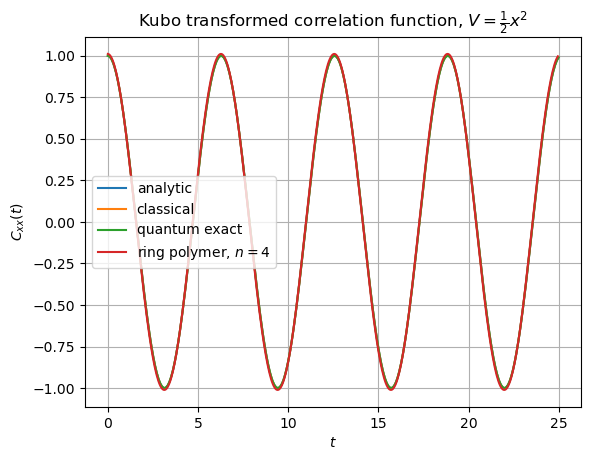

<Figure size 640x480 with 0 Axes>

In [119]:
plt.plot(classical_harmonic[0], np.cos(classical_harmonic[0]),label='analytic')
plt.plot(classical_harmonic[0], classical_harmonic[1],label='classical')
plt.plot(exact_harmonic[0], exact_harmonic[1],label='quantum exact')
plt.plot(polymer_harmonic[0], polymer_harmonic[1],label=r'ring polymer, $n=4$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_harmonic.png')
plt.show()
plt.clf()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [126]:
beta = 1
n = 4*beta
if compute == 1:
    polymer_slightly_anharmonic_highT = ring_polymer(-1,4.5,1.3,10000,20000,'slightly_anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/slightly_anharmonic_highT.npy', polymer_slightly_anharmonic_highT)

100%|██████████| 20000/20000 [00:13<00:00, 1467.35it/s]


In [127]:
polymer_slightly_anharmonic_highT = np.load(f'{polymer_path}/slightly_anharmonic_highT.npy')

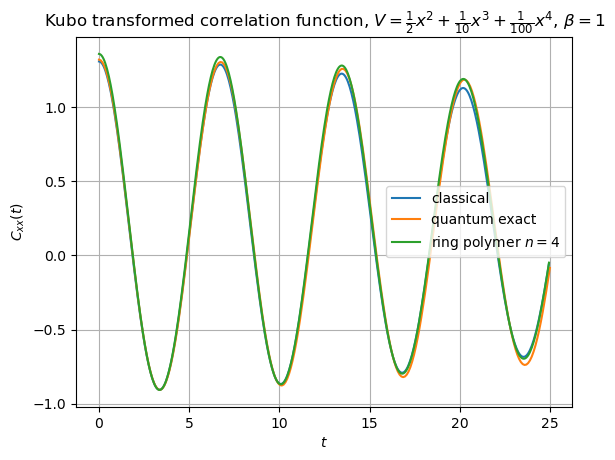

<Figure size 640x480 with 0 Axes>

In [129]:
plt.plot(classical_slightly_anharmonic_highT[0], classical_slightly_anharmonic_highT[1],label='classical')
plt.plot(exact_slightly_anharmonic_highT[0], exact_slightly_anharmonic_highT[1],label='quantum exact')
plt.plot(polymer_slightly_anharmonic_highT[0], polymer_slightly_anharmonic_highT[1],label=r'ring polymer $n=4$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_slightly_anharmonic_highT.png')
plt.show()
plt.clf()

$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [130]:
beta = 8
n = 4*beta
if compute == 1:
    polymer_slightly_anharmonic_lowT = ring_polymer(0,3,1,20000,10000,'slightly_anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/slightly_anharmonic_lowT.npy', polymer_slightly_anharmonic_lowT)

100%|██████████| 10000/10000 [00:12<00:00, 770.07it/s]


In [131]:
polymer_slightly_anharmonic_lowT = np.load(f'{polymer_path}/slightly_anharmonic_lowT.npy')

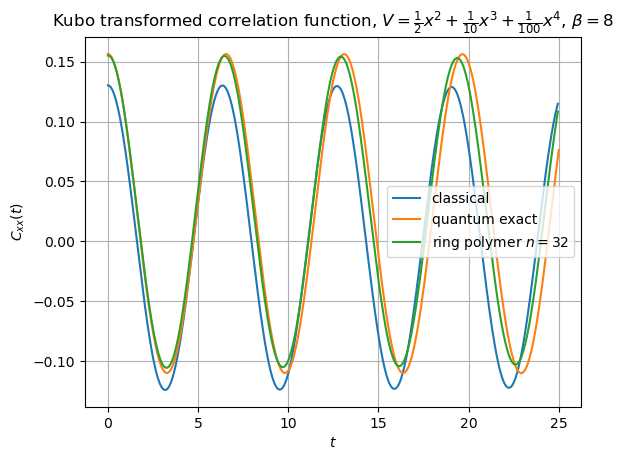

<Figure size 640x480 with 0 Axes>

In [132]:
plt.plot(classical_slightly_anharmonic_lowT[0], classical_slightly_anharmonic_lowT[1],label='classical')
plt.plot(exact_slightly_anharmonic_lowT[0], exact_slightly_anharmonic_lowT[1],label='quantum exact')
plt.plot(polymer_slightly_anharmonic_lowT[0], polymer_slightly_anharmonic_lowT[1],label=r'ring polymer $n=32$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_slightly_anharmonic_lowT.png')
plt.show()
plt.clf()

$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [63]:
beta = 1
n = 4*beta

if compute == 1:
    polymer_anharmonic_highT = ring_polymer(0,3,1,10000,10000,'anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/anharmonic_highT.npy', polymer_anharmonic_highT)

100%|██████████| 10000/10000 [00:08<00:00, 1225.68it/s]


In [64]:
polymer_anharmonic_highT = np.load(f'{polymer_path}/anharmonic_highT.npy')

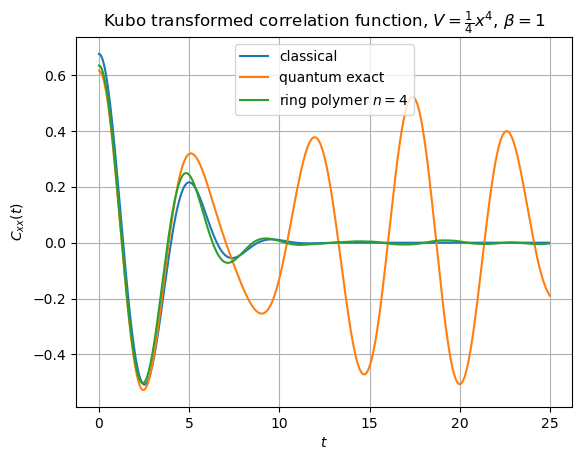

<Figure size 640x480 with 0 Axes>

In [65]:
plt.plot(classical_anharmonic_highT[0], classical_anharmonic_highT[1],label='classical')
plt.plot(exact_anharmonic_highT[0], exact_anharmonic_highT[1],label='quantum exact')
plt.plot(polymer_anharmonic_highT[0], polymer_anharmonic_highT[1],label=r'ring polymer $n=4$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_anharmonic_highT.png')
plt.show()
plt.clf()

$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [66]:
beta = 8
n = 4*beta
if compute == 1:
    polymer_anharmonic_lowT = ring_polymer(0,3,0.8,10000,10000,'anharmonic',25,0.05,beta,n)
    np.save(f'{polymer_path}/anharmonic_lowT.npy', polymer_anharmonic_lowT)

100%|██████████| 10000/10000 [00:08<00:00, 1161.94it/s]


In [67]:
polymer_anharmonic_lowT = np.load(f'{polymer_path}/anharmonic_lowT.npy')

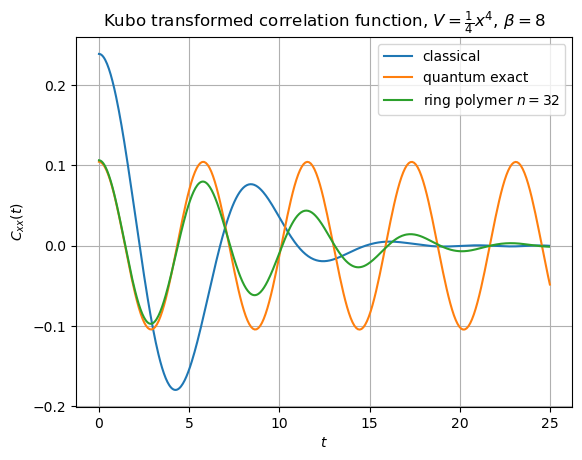

<Figure size 640x480 with 0 Axes>

In [68]:
plt.plot(classical_anharmonic_lowT[0], classical_anharmonic_lowT[1],label='classical')
plt.plot(exact_anharmonic_lowT[0], exact_anharmonic_lowT[1],label='quantum exact')
plt.plot(polymer_anharmonic_lowT[0], polymer_anharmonic_lowT[1],label=r'ring polymer $n=32$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.savefig('ring_polymer_anharmonic_lowT.png')
plt.show()
plt.clf()

# Cube Correlation

In [72]:
def cube_exact_quantum(n_max, beta, potential, t_end, t_N):

    potential_coefficients = {
        'harmonic': [1/2,0,0],
        'slightly_anharmonic': [1/2,1/10,1/100],
        'anharmonic': [0,0,1/4]
    }

    dim = n_max + 4

    # Annihilation operator
    a = np.zeros((dim, dim))
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)

    # Creation operator
    adag = a.T

    # Position operator
    x = np.sqrt(hbar/(2*m)) * (a + adag)

    x2 = x @ x
    x3 = x2 @ x
    x4 = x3 @ x

    x_powers = [x2,x3,x4]

    V = np.zeros((dim,dim))
    for i in range(0,3):
        V += potential_coefficients[potential][i] * x_powers[i]

    # Kinetic energy operator

    dv = np.sqrt(m * hbar / 2) * (adag - a)

    T = -(dv @ dv) / (2 * m)

    # Hamiltonian
    H = T + V

    H = H[:n_max,:n_max]

    # Diagonalize Hamiltonian
    E, psi = eigh(H)

    # Partition function
    exp_beta_E = np.exp(-beta * E)
    Z = np.sum(exp_beta_E)

    # Operator A = x
    A = x3[:n_max,:n_max]
    A_mat = psi.T @ A @ psi

    # Build outer products for broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            exp_beta_E[:, None],
            (exp_beta_E[None, :] - exp_beta_E[:, None]) / (beta * dE)
        )

    # Matrix element product (A_nm * A_mn)
    A_prod = A_mat * A_mat.T

    # Time evolution
    times = np.linspace(0, t_end, t_N)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, A_prod).real / Z

    return times, C_t

In [82]:
def cube_classical(x_low, x_up, x_step, v_low, v_up, v_step, potential, time, delta_t, beta):
    C_time = np.arange(0, time, delta_t)
    N = len(C_time)

    energy_map = {
        'harmonic': harmonic,
        'slightly_anharmonic': slightly_anharmonic,
        'anharmonic': anharmonic
    }
    energy = energy_map[potential]
    verlet_map = {
        'harmonic': verlet_harmonic,
        'slightly_anharmonic': verlet_slightly_anharmonic,
        'anharmonic': verlet_anharmonic
    }
    verlet = verlet_map[potential]

    C_func = np.zeros(N)
    partition_function = 0.0

    x_vals = np.arange(x_low, x_up, x_step)
    v_vals = np.arange(v_low, v_up, v_step)

    for x_init in tqdm(x_vals, desc="Classical Sampling"):
        for v_init in v_vals:
            E = energy(x_init) + 0.5 * m * v_init**2
            weight = np.exp(-beta * E)
            x_traj, _ = verlet(x_init, v_init, time, delta_t)

            C_func += x_traj**3 * x_init**3 * weight
            partition_function += weight

    C_func /= partition_function
    return C_time, C_func

In [83]:
@njit
def polymer_verlet_cube_harmonic(x_init, v_init, k_eff, time, delta_t, n):
    N = int(time / delta_t)
    x_verlet = np.zeros((N, n))
    v_verlet = np.zeros((N, n))
    x_verlet[0, :] = x_init
    v_verlet[0, :] = v_init

    for i in range(N - 1):
        x = x_verlet[i]
        v = v_verlet[i]
        f = F_harmonic(x)

        # Efficient spring force using periodic boundary
        x_fwd = np.empty(n)
        x_bwd = np.empty(n)
        for j in range(n):
            x_fwd[j] = x[(j + 1) % n]
            x_bwd[j] = x[(j - 1 + n) % n]
        spring_force = -k_eff * (2 * x - x_fwd - x_bwd)

        x_new = x + delta_t * v + (delta_t**2 / (2 * m)) * (f + spring_force)
        x_verlet[i + 1] = x_new

        f_new = F_harmonic(x_new)
        for j in range(n):
            x_fwd[j] = x_new[(j + 1) % n]
            x_bwd[j] = x_new[(j - 1 + n) % n]
        spring_force_new = -k_eff * (2 * x_new - x_fwd - x_bwd)

        v_new = v + (delta_t / (2 * m)) * (f + spring_force + f_new + spring_force_new)
        v_verlet[i + 1] = v_new

    N = x_verlet.shape[0]
    x_cube_avg = np.empty(N)
    for i in range(N):
        s = 0.0
        for j in range(x_verlet.shape[1]):
            s += x_verlet[i, j]**3
        x_cube_avg[i] = s / x_verlet.shape[1]
    return x_cube_avg

In [84]:
def cube_ring_polymer(x_mean, x_std, metropolis_step_size, metropolis_num_step, num_sample, time, delta_t, beta, n):
    beta_n = beta / n
    k_eff = m / (beta_n**2 * hbar**2)

    C_time = np.arange(0, time, delta_t)
    N = len(C_time)
    C_func = np.zeros(N)

    for _ in tqdm(range(num_sample)):
        x_init = Metropolis_harmonic(x_mean, x_std, k_eff,
                                       metropolis_step_size, metropolis_num_step, beta_n, n)
        v_init = np.random.normal(0.0, np.sqrt(1 / (m * beta_n)), n)
        mean_x_cube_init = np.mean(x_init**3)
        x_cube_avg = polymer_verlet_cube_harmonic(x_init, v_init, k_eff, time, delta_t, n)
        C_func += (x_cube_avg * mean_x_cube_init) / num_sample

    return C_time, C_func

## $\beta=1$

In [99]:
beta = 1
n = 4*beta

if compute == 1:
    cube_exact_harmonic_highT = cube_exact_quantum(20,beta,'harmonic',25,250)
    cube_classical_harmonic_highT = cube_classical(-5.5,5.5,0.1,-5.5,5.5,0.1,'harmonic',25,0.05,beta)
    cube_ring_polymer_harmonic_highT = cube_ring_polymer(0,5.5,1.5,10000,10000,25,0.05,beta,n)
    np.save(f'{cube_path}/exact_harmonic_highT.npy', cube_exact_harmonic_highT)
    np.save(f'{cube_path}/classical_harmonic_highT.npy', cube_classical_harmonic_highT)
    np.save(f'{cube_path}/ring_polymer_harmonic_highT.npy', cube_ring_polymer_harmonic_highT)

100%|██████████| 10000/10000 [00:06<00:00, 1449.96it/s]


In [100]:
C_cube_exact_harmonic_highT = np.load(f'{cube_path}/exact_harmonic_highT.npy')
C_cube_classical_harmonic_highT = np.load(f'{cube_path}/classical_harmonic_highT.npy')
C_cube_ring_polymer_harmonic_highT = np.load(f'{cube_path}/ring_polymer_harmonic_highT.npy')

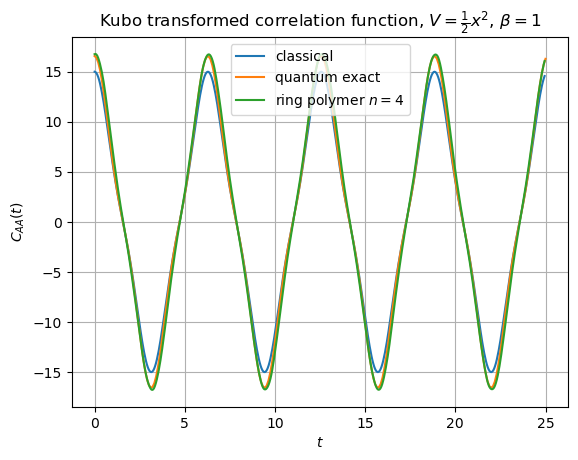

<Figure size 640x480 with 0 Axes>

In [101]:
plt.plot(C_cube_classical_harmonic_highT[0],C_cube_classical_harmonic_highT[1],label='classical')
plt.plot(C_cube_exact_harmonic_highT[0],C_cube_exact_harmonic_highT[1],label='quantum exact')
plt.plot(C_cube_ring_polymer_harmonic_highT[0],C_cube_ring_polymer_harmonic_highT[1],label=r'ring polymer $n=4$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{AA}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.savefig('CAA_harmonic_highT.png')
plt.show()
plt.clf()

## $\beta=8$

In [93]:
beta = 8
n = 4*beta

if compute == 1:
    C_cube_exact_harmonic_lowT = cube_exact_quantum(10,beta,'harmonic',25,250)
    C_cube_classical_harmonic_lowT = cube_classical(-5,5,0.05,-4,4,0.1,'harmonic',25,0.05,beta)
    C_cube_ring_polymer_harmonic_lowT = cube_ring_polymer(0,4.5,1.2,10000,10000,25,0.05,beta,n)
    np.save(f'{cube_path}/exact_harmonic_lowT.npy', C_cube_exact_harmonic_lowT)
    np.save(f'{cube_path}/classical_harmonic_lowT.npy', C_cube_classical_harmonic_lowT)
    np.save(f'{cube_path}/ring_polymer_harmonic_lowT.npy', C_cube_ring_polymer_harmonic_lowT)

100%|██████████| 10000/10000 [00:08<00:00, 1186.33it/s]


In [94]:
C_cube_exact_harmonic_lowT = np.load(f'{cube_path}/exact_harmonic_lowT.npy')
C_cube_classical_harmonic_lowT = np.load(f'{cube_path}/classical_harmonic_lowT.npy')
C_cube_ring_polymer_harmonic_lowT = np.load(f'{cube_path}/ring_polymer_harmonic_lowT.npy')

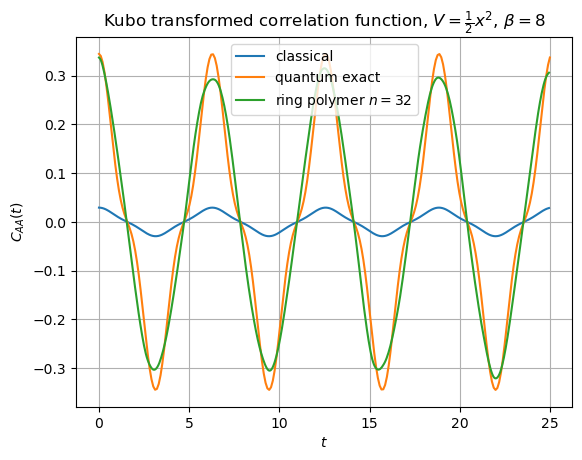

<Figure size 640x480 with 0 Axes>

In [95]:
plt.plot(C_cube_classical_harmonic_lowT[0],C_cube_classical_harmonic_lowT[1],label='classical')
plt.plot(C_cube_exact_harmonic_lowT[0],C_cube_exact_harmonic_lowT[1],label='quantum exact')
plt.plot(C_cube_ring_polymer_harmonic_lowT[0],C_cube_ring_polymer_harmonic_lowT[1],label=r'ring polymer $n=32$')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{AA}(t)$')
plt.title(r'Kubo transformed correlation function, $V=\frac{1}{2}x^2$, $\beta=8$')
plt.grid()
plt.legend()
plt.savefig('CAA_harmonic_lowT.png')
plt.show()
plt.clf()